This notebook accesses the Gulf Stream AOI and computes the threshold and climatology using the Eric Oliver MHW code. It uses dask for parellelization.

This is the code used in the script `oliver_geopolar_gulf.py`. This notebook also contains documentation of the results of different runs and a legend of run numbers.

In [1]:
from datetime import datetime

import numpy as np
import xarray as xr
import zarr
import dask
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

client = Client()

## Access Data

Use xarray to open an xarray (dask array) dataset.

In [4]:
print('access data ------')

filepath = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/noaa-coastwatch-geopolar-sst-feedstock/noaa-coastwatch-geopolar-sst.zarr'
geopolar = xr.open_zarr(filepath)
geopolar = geopolar.analysed_sst

min_lat, max_lat, min_lon, max_lon = (34, 35, -65, -64)  # (32, 53, -79, -42)
geopolar = geopolar.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon)).isel(time=slice(0, 5))

access data ------


## Preprocessing

- convert time from datetime to ordinal days
- mask land values

In [16]:
def format_time(time_np):
    # Format time values
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [17]:
print('preprocessing ---------')

time_ordinal = format_time(geopolar.time.values)

preprocessing ---------


In [18]:
sst_np = geopolar.values

# sst_np[np.isnan(sst_np)] = 9999

## Loop

Pick up those weights (hand them to dask) then ask them to lift.

In [19]:
print('loop --------')

# Create fake input data
lat_size, long_size, time_size = len(geopolar.lat), len(geopolar.lon), len(geopolar.time)
# data = da.random.random_integers(0, 30, size=(1_000, long_size, lat_size), chunks=(-1, 10, 10))  # size = (time, longitude, latitude)
data = da.from_array(sst_np, chunks=(-1, 150, 150))
# time = np.arange(730_000, 731_000)  # time in ordinal days
time = time_ordinal

# define a wrapper to rearrange arguments
def func1d_climatology(arr, time):
   _, point_clim = mhw.detect(time, arr)
   # return climatology
   return point_clim['seas']

# define a wrapper to rearrange arguments
def func1d_threshold(arr, time):
   _, point_clim = mhw.detect(time, arr)
   # return threshold
   return point_clim['thresh']

# output arrays
full_climatology = da.zeros_like(data)
full_threshold = da.zeros_like(data)

climatology = da.apply_along_axis(func1d_climatology, 0, data, time=time, dtype=data.dtype, shape=(time_size,))
threshold = da.apply_along_axis(func1d_threshold, 0, data, time=time, dtype=data.dtype, shape=(time_size,))

loop --------


In [20]:
%%time

print('computing climatology ----- ')

climatology.compute()

computing climatology ----- 
CPU times: user 77.5 ms, sys: 25.9 ms, total: 103 ms
Wall time: 1.94 s


array([[[126.15703164, 126.16122929, 126.16625878, ..., 126.26522335,
         126.27026564, 126.27445049],
        [126.13521158, 126.13942202, 126.14612801, ..., 126.25682806,
         126.26354685, 126.2694082 ],
        [126.10921946, 126.1167701 , 126.12432074, ..., 126.23921843,
         126.24426073, 126.25264322],
        ...,
        [125.94735422, 125.95237092, 125.96161086, ..., 126.05722243,
         126.05470128, 126.05303758],
        [125.93728244, 125.94233753, 125.95238372, ..., 126.05554593,
         126.05302478, 126.05219293],
        [125.92722345, 125.93394224, 125.94232473, ..., 126.05050364,
         126.04882714, 126.04799529]],

       [[135.86141869, 135.86593923, 135.87135561, ..., 135.97793284,
         135.983363  , 135.98786975],
        [135.83792016, 135.84245448, 135.84967632, ..., 135.96889176,
         135.97612738, 135.98243959],
        [135.80992865, 135.81806011, 135.82619156, ..., 135.94992755,
         135.95535771, 135.964385  ],
        ...,


In [24]:
%%time
print('computing threshold ----- ')

threshold.compute()

computing threshold ----- 
CPU times: user 77.7 ms, sys: 21 ms, total: 98.7 ms
Wall time: 1.87 s


array([[[126.27109237, 126.28619109, 126.30296119, ..., 126.39522489,
         126.3910298 , 126.39019283],
        [126.26522079, 126.28199857, 126.30128725, ..., 126.39354071,
         126.39522233, 126.39438536],
        [126.24425305, 126.26270476, 126.28451203, ..., 126.38263963,
         126.38012361, 126.38348428],
        ...,
        [126.02786452, 126.03541516, 126.04129186, ..., 126.21322632,
         126.21573723, 126.21657675],
        [126.01780297, 126.02786452, 126.03374122, ..., 126.21490026,
         126.21573723, 126.21909534],
        [126.01193139, 126.01948203, 126.02367967, ..., 126.21070773,
         126.21154726, 126.21657675]],

       [[135.98425332, 136.00051348, 136.01857359, ..., 136.11793449,
         136.11341671, 136.11251536],
        [135.97793008, 135.99599846, 136.01677089, ..., 136.11612076,
         136.11793174, 136.11703038],
        [135.95534944, 135.97522051, 135.99870527, ..., 136.10438114,
         136.10167158, 136.10529076],
        ...,


## Save Dataset

In [70]:
clim = xr.DataArray(climatology, coords = geopolar.coords, dims=geopolar.dims)
thresh = xr.DataArray(threshold, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')
thresh = thresh.rename('threshold')

# add array attributes
clim.attrs['comment'] = 'climatology computed using Eric Oliver marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

thresh.attrs['comment'] = '90th percentile treshold values computed using Eric Oliver ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'


In [75]:
# merge into a single dataset
output = xr.merge([clim, thresh])

# assign global metadata
output = output.assign_attrs(geopolar.attrs)

# add new fields
output.attrs['source_dataset'] = 'Coastwatch Geopolar SST'

# drop obsolute fields from original attributes
output.attrs.pop('long_name')
output.attrs.pop('reference')
output.attrs.pop('comment')


'Analysed SST for each ocean grid point'

## Save

In [80]:
output.to_netcdf('./TEST.nc')

: 

### Old code - saving data arrays individually

In [15]:
print('saving datasets ------------')

clim_ds = xr.DataArray(climatology, coords = geopolar.coords, dims=geopolar.dims).to_dataset()

clim_ds.to_netcdf('../../data/gulfstream_climatology_TEST.nc')

saving datasets ------------


In [8]:
thresh_ds = xr.DataArray(threshold, coords = geopolar.coords, dims=geopolar.dims).to_dataset()

thresh_ds.to_netcdf('../../data/gulfstream_threshold_TEST.nc')

# Checking output

In [1]:
import xarray as xr
import numpy as np

In [7]:
clim_calc = xr.open_dataset('/data/pacific/rwegener/gulfstream_threshold.nc')
anom_calc = xr.open_dataset('/data/pacific/rwegener/gulfstream_anomaly.nc')

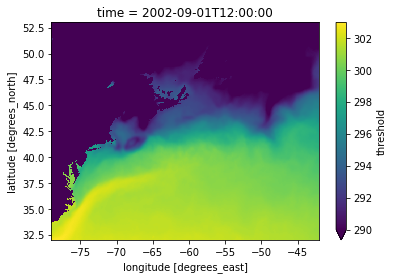

In [6]:
clim_calc.threshold.isel(time=0).plot(vmin=290)

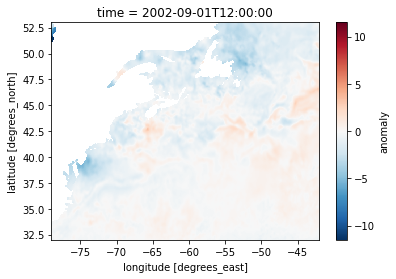

In [8]:
anom_calc.anomaly.isel(time=0).plot()

In [ ]:
xr.merge([clim_array2, clim_array])

### Debugging the index error

In [12]:
np.where(np.isnan(thresh) != 1)

(array([   0,    0,    0, ..., 7133, 7133, 7133]),
 array([300, 300, 300, ..., 419, 419, 419]),
 array([  0,   1,   2, ..., 147, 148, 149]))

In [10]:
ocean_only = clim.sel(lat=slice(32, 42), lon=slice(-68, -42))

In [ ]:
ocean_only.isel(time=0)

In [29]:
all_nans = clim_array

np.sum(np.isnan(ocean_only.isel(time=1000).values))

104000

In [30]:
np.where(np.isnan(ocean_only) != 1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [25]:
clim_array.isel(time=0, lat=slice(290, 310), lon=slice(0, 5))

<xarray.DataArray 'func1d_climatology-along-axis-18e5467e1308c81432271246150c40ce' (lat: 20, lon: 5)>
array([[  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.],
       [9999., 9999., 9999., 9999., 9999.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 46.53 46.58 46.62 46.67 ... 47.33 47.38 47.42 47.47
  * lon      (lon) float32 -78.97 -78.93 -78.88 -78.82 -78.78
    time     datetime64[ns] 2002-09-01T12:00:00

# Runs

Run 1 - climatology computed, threshold failed during save (don't know why). Climatology returned all nans, except for 9999 values.
Time unknown (because program died before threshold was completed)

Learned -- values seem to be 9999 over land and nan over water. Is the nan masking screwing it up?

Run 2 - open ocean only, no masking -- (32, 42, -68, -42)
climatology computed. Data seems reaonsable. 

Run 3 - moving back toward land, masking with 0 instead of 9999 -- (32, 42, -79, -68)

Run 4- Full area, 0 masking, climatology only, calculated in ~45 minutes then tried to save for close to 2 hours before I manually killed it. It seemded that the workers were slowly getting killed. Only 1 of 16 was left alive when I killed the process.

Run 4 (`/data/pacific`) - Same setup as run4, but running with save in the pacific disk

In [1]:
import imageio

import xarray as xr
import numpy as np

In [2]:
clim = xr.open_dataset('/data/pacific/rwegener/gulfstream_climatology.nc')

In [3]:
clim_full = clim

In [13]:
clim_full

<xarray.Dataset>
Dimensions:          (lat: 420, lon: 740, time: 7134)
Coordinates:
  * lat              (lat) float32 32.03 32.08 32.12 32.17 ... 52.88 52.92 52.97
  * lon              (lon) float32 -78.97 -78.93 -78.88 ... -42.12 -42.08 -42.03
  * time             (time) datetime64[ns] 2002-09-01T12:00:00 ... 2022-03-20...
Data variables:
    climatology SST  (time, lat, lon) float32 ...

In [2]:
# Open datasets
clim_west = xr.open_dataset('../../data/gulfstream_climatology_run3.nc')
clim_east = xr.open_dataset('../../data/gulfstream_climatology_run2.nc')

In [6]:
clim_east

<xarray.Dataset>
Dimensions:                                                         (lat: 200, lon: 520, time: 7134)
Coordinates:
  * lat                                                             (lat) float32 ...
  * lon                                                             (lon) float32 ...
  * time                                                            (time) datetime64[ns] ...
Data variables:
    func1d_climatology-along-axis-f5bb16d56e7dc4ac8250fd7dfb29aed6  (time, lat, lon) float32 ...

In [9]:
clim_west = clim_west.rename({'func1d_climatology-along-axis-0ad8b07b4b464291ec715bc98f87c505': 'climatology'})
clim_east = clim_east.rename({'func1d_climatology-along-axis-f5bb16d56e7dc4ac8250fd7dfb29aed6': 'climatology'})

In [10]:
# Stick the two datasets together
clim_full = xr.concat([clim_west, clim_east], dim="lon")

In [4]:
clim_full = clim_full.rename({'climatology': 'climatology SST'})

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

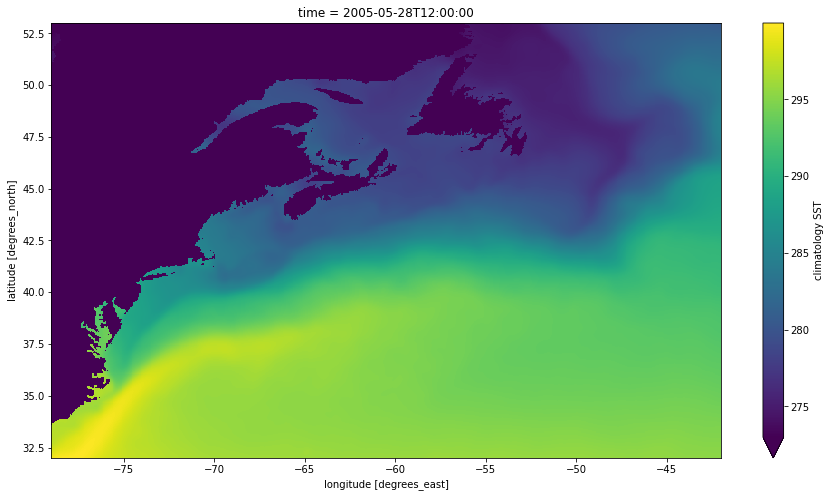

In [10]:
clim_full['climatology SST'].isel(time=1000).plot(vmin=273)

In [11]:
clim_2003 = clim_full.sel(time='2003')

In [15]:
filenames = []
for i in range(len(clim_2003.time)):
    # plot the map
    clim_2003['climatology SST'].isel(time=i).plot(vmin=273)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


In [16]:
with imageio.get_writer('SST_climatology.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
from xmovie import Movie

In [ ]:
mov = Movie(clim_full.climatology)
mov.save('climatoogy.mp4')